In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch import tensor as tt
import torch.nn.functional as F
import torchvision.transforms as tforms
from torchvision.transforms import v2

transform = tforms.ToTensor()

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(180)
])
device = 'cpu'
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

In [2]:
ZouGam = np.load("/Users/alexgagliano/Documents/Research/GalaxyAutoencoder/FullSample_26k_photoz_wOrientation.npz")

In [3]:
images1 = np.load("/Users/alexgagliano/Documents/Research/GalaxyAutoencoder/GAMASEDs/Gama_16k_specz.npz")['x']
images2 = np.load("/Users/alexgagliano/Documents/Research/GalaxyAutoencoder//ZouSEDs/Zou_10k_specz.npz")['x']
all_images = np.concatenate([images1, images2])

rsp_data = np.load("/Users/alexgagliano/Documents/Research/GalaxyAutoencoder/RedSpirals.npz")
gp_data = np.load("/Users/alexgagliano/Documents/Research/GalaxyAutoencoder/GreenPeas.npz")

rsps_images = rsp_data['x']
rsps_features = rsp_data['y']

gp_images = gp_data['x']
gp_features = gp_data['y']

In [4]:
images_rescaled = ZouGam['x'].astype(np.float32)
labels = ZouGam['y'].astype(np.float32)

In [5]:
# random split
N = len(images_rescaled)

np.random.seed(12345)
indices = np.random.permutation(N)

train_idxs = indices[:int(0.8*N)]
valid_idxs = indices[int(0.8*N):]

class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [6]:
def transform_images(images, all_images):
    #transform images
    #normalization scaling taken from https://arxiv.org/pdf/2005.12039.pdf
    meanmax_g = np.nanmean([np.nanmax(x) for x in all_images[:, :, :, 0]])
    meanmax_r = np.nanmean([np.nanmax(x) for x in all_images[:, :, :, 1]])
    meanmax_z = np.nanmean([np.nanmax(x) for x in all_images[:, :, :, 2]])
    
    images_rescaled = []
    for img in images:    
        beta = 10.
        
        test_g = np.tanh(np.arcsinh(beta*img[:, :, 0]/meanmax_g))
        test_r = np.tanh(np.arcsinh(beta*img[:, :, 1]/meanmax_r))
        test_z = np.tanh(np.arcsinh(beta*img[:, :, 2]/meanmax_z))
    
        newImg = np.moveaxis(np.array([test_z, test_r, test_g]), 0, -1)
        
        images_rescaled.append(newImg)
    return images_rescaled

In [7]:
rsps_images_rescaled = transform_images(rsps_images, all_images)
gp_images_rescaled = transform_images(gp_images, all_images)

In [8]:
all_vals_rescaled = np.concatenate([rsps_images_rescaled, gp_images_rescaled, np.array(images_rescaled)[valid_idxs]])
all_vals_rescaled = [F.interpolate(transform(x).unsqueeze(0), size=(69, 69), mode='bicubic').squeeze() for x in all_vals_rescaled]
y_anomaly = np.concatenate([np.ones(294), [2]*13, np.zeros(len(images_rescaled[valid_idxs]))])

In [9]:
rsps_images_rescaled = [F.interpolate(transform(x).unsqueeze(0), size=(69, 69), mode='bicubic').squeeze() for x in rsps_images_rescaled]
gp_images_rescaled = [F.interpolate(transform(x).unsqueeze(0), size=(69, 69), mode='bicubic').squeeze() for x in gp_images_rescaled]
onlyval_images_rescaled = [F.interpolate(transform(x).unsqueeze(0), size=(69, 69), mode='bicubic').squeeze() for x in images_rescaled[valid_idxs]]

In [10]:
#define and load model 
class ConvVAE(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.d = d

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, padding=1),    # 35x35
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 2, padding=1),   # 18x18
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*18*18, 2*d)
        )

        self.dec1 = nn.Sequential(
            nn.Linear(d, 32*18*18),
            nn.Unflatten(1, (32, 18, 18)), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 1, padding=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, 3, 1, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        mu_logvar = x.view(-1, 2, self.d)

        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]

        z = self.reparameterize(mu, logvar)
        x_hat = self.dec1(z)
        x_hat = F.interpolate(x_hat, size=(35, 35), mode='bilinear')
        x_hat = self.dec2(x_hat)
        x_hat = F.interpolate(x_hat, size=(69, 69), mode='bilinear')
        x_hat = self.dec3(x_hat)
        return x_hat, mu, logvar

In [11]:
#load up the physics-informed model
model = ConvVAE(d=5).to(device)
model.load_state_dict(torch.load("/Users/alexgagliano/Documents/Research/GalaxyAutoencoder/cannon/models/cVAE_ZouGama26k_d5_orientation_5b0MSE_1695923316.h5", map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
#now, compare the same with the uninformed model: 
model_uninf = ConvVAE(d=5).to(device)
model_uninf.load_state_dict(torch.load("/Users/alexgagliano/Documents/Research/GalaxyAutoencoder/cannon/models/cVAE_ZouGama26k_d5_uninformed_fixBeta.h5", map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [14]:
val_ds = GalaxyDataset(all_vals_rescaled, y_anomaly, None)
valid_loader = DataLoader(
    val_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

In [15]:
def make_meshgrid(x, y, xrange, yrange, h=.2):
    x_min, x_max = xrange[0] - 1, xrange[1] + 1
    y_min, y_max = yrange[0] - 1, yrange[1] + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_boundary(df, features, ax, cmap, xrange, yrange, alpha=0.5):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(df[features].values, df['Anomaly'].values)
    clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    clf.fit(X_res, y_res)
    
    # Set-up grid for plotting.
    X0, X1 = df[features[0]].values, df[features[1]].values
    xx, yy = make_meshgrid(X0, X1, xrange, yrange)
    return plot_contours(ax, clf, xx, yy, cmap=cmap, alpha=alpha)

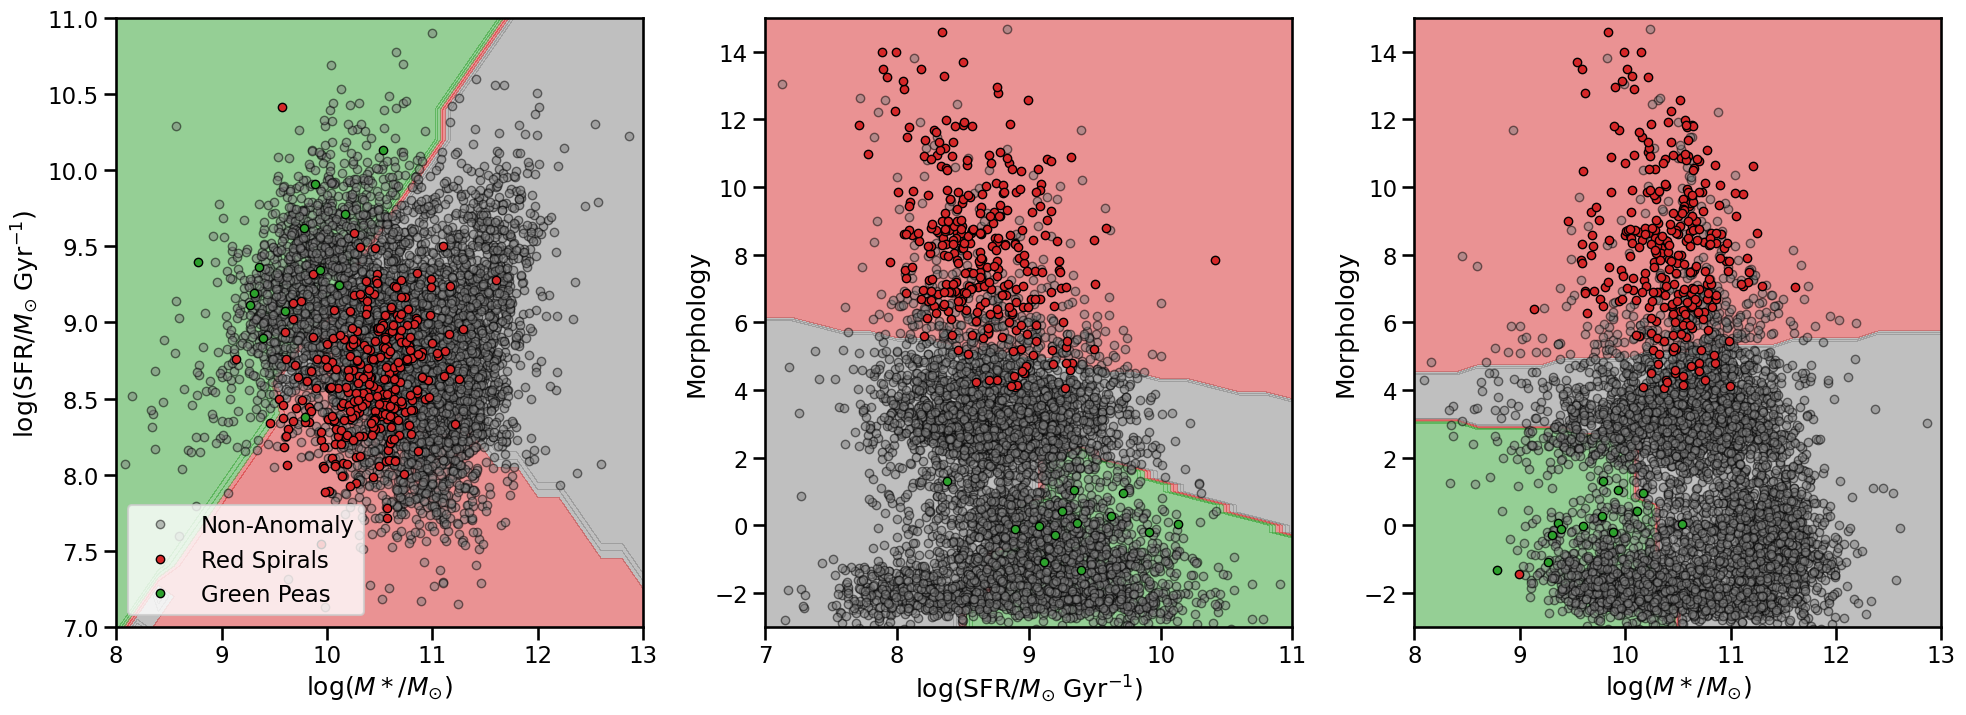

In [16]:
mu_list = []
y_list = []
valid_loss = []

for x, y in valid_loader:
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    mu_list.append(mu.detach().numpy())
    y_list.append(y.detach().numpy())

mu_list = np.concatenate(mu_list)
y_list = np.concatenate(y_list)

df = pd.DataFrame(data = np.vstack([mu_list.T, y_list]).T, columns=['RotAngle', 'z', 'M*', 'SFR', 'Morphology', 'Anomaly'])# columns=['RotAngle', 'z', 'M*', 'SFR', 'Morphology', 'Anomaly'])

sns.set_context("talk")
anomaly = {0:'Non-Anomaly', 1:'Red Spirals', 2:'Green Peas'}
cols = {0:'gray', 1:'tab:red', 2:'tab:green'}
cmap = LinearSegmentedColormap.from_list('Anomaly', ['grey', 'tab:red', 'tab:green'], N=3)
groups = df.groupby('Anomaly')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7.5))
axs = ax.ravel()

axs[0].set_xlim((8, 13))
axs[0].set_ylim((7, 11))
axs[1].set_xlim((7, 11))
axs[1].set_ylim((-3, 15))
axs[2].set_xlim((8, 13))
axs[2].set_ylim((-3, 15))

plot_decision_boundary(df, ['M*', 'SFR'], axs[0], cmap, (8, 13), (7, 11), 0.5)
plot_decision_boundary(df, ['SFR', 'Morphology'], axs[1], cmap, (7, 11), (-3, 15), 0.5)
plot_decision_boundary(df,  ['M*', 'Morphology'], axs[2], cmap, (8, 13), (-3, 15), 0.5)

for name, group in groups:
    if name == 0:
        alpha=0.5
    else:
        alpha = 1

    axs[0].plot(group['M*'], group['SFR'], marker='o', linestyle='', markersize=6, color=cols[name], label=anomaly[name], lw=0.5, mec='k', alpha=alpha)
    axs[1].plot(group['SFR'], group['Morphology'], marker='o', linestyle='', markersize=6, color=cols[name], label=anomaly[name], lw=0.5, mec='k', alpha=alpha)
    axs[2].plot(group['M*'], group['Morphology'], marker='o', linestyle='', markersize=6, color=cols[name], label=anomaly[name], lw=0.5, mec='k', alpha=alpha)
    axs[0].legend()
    axs[0].set_xlabel(r"log($M*/M_{\odot}$)");
    axs[0].set_ylabel(r"log(SFR/$M_{\odot}\;\rm{Gyr}^{-1}$)");
    axs[1].set_xlabel(r"log(SFR/$M_{\odot}\;\rm{Gyr}^{-1}$)");
    axs[1].set_ylabel("Morphology");
    axs[2].set_xlabel(r"log($M*/M_{\odot}$)");
    axs[2].set_ylabel("Morphology");
plt.tight_layout()
#plt.savefig("AnomalyDetection_physicsVAE.png",dpi=200, bbox_inches='tight')

/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

[[0.93168772 0.04955989 0.01875239]
 [0.02380952 0.97619048 0.        ]
 [0.         0.         1.        ]]


/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

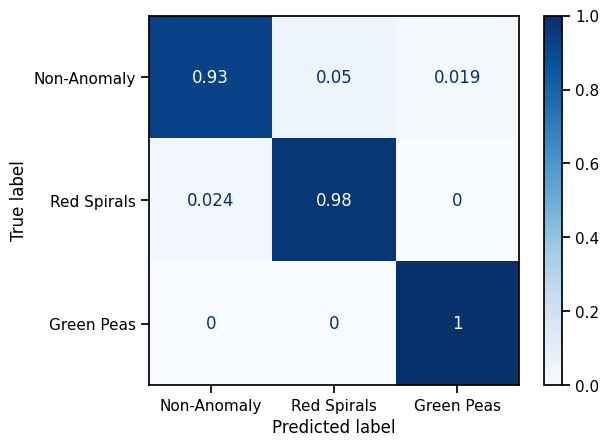

In [17]:
# create a confusion matrix distinguishing between classes, using all 5 features
sns.set_context("notebook")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.drop(columns=['Anomaly']), df['Anomaly'])
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_res, y_res)
y_pred = clf.predict(df.drop(columns=['Anomaly']))
y_true = df['Anomaly']

disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    df.drop(columns=['Anomaly']),
    y_true,
    display_labels=['Non-Anomaly', 'Red Spirals', 'Green Peas'],
    cmap=plt.cm.Blues,
    normalize='true',
)

print(disp.confusion_matrix)
plt.show()

In [20]:
gp_ds = GalaxyDataset(gp_images_rescaled, gp_features, None)
gp_loader = DataLoader(
    gp_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

rsps_ds = GalaxyDataset(rsps_images_rescaled, rsps_features, None)
rsps_loader = DataLoader(
    rsps_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

onlyval_ds = GalaxyDataset(onlyval_images_rescaled, labels[valid_idxs], None)
onlyval_loader = DataLoader(
    onlyval_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

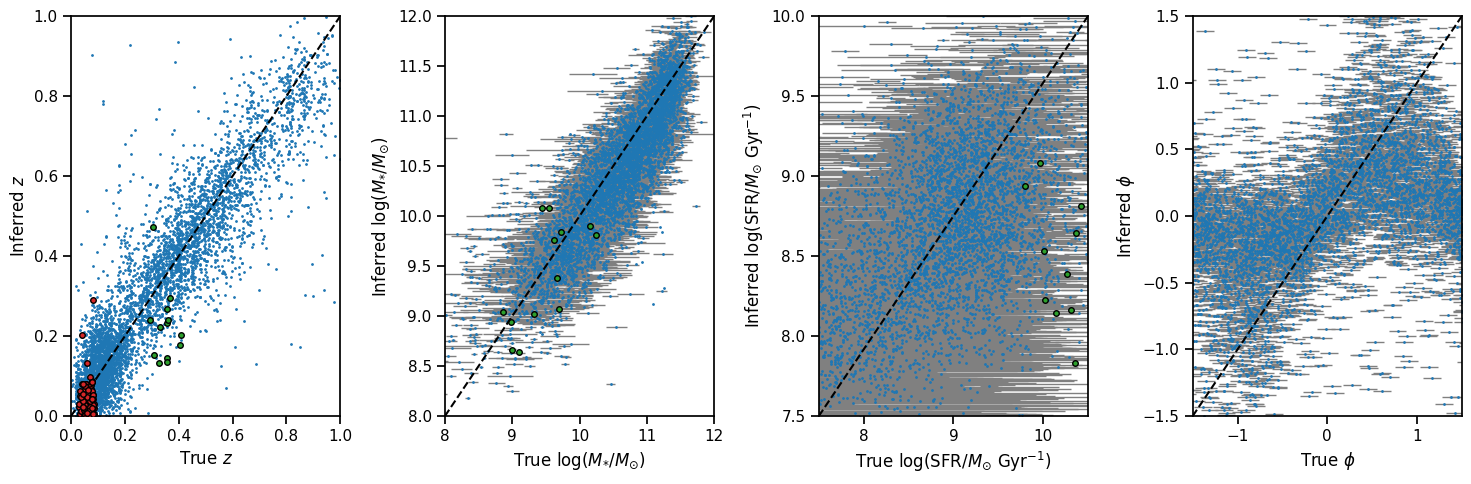

In [89]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

mu_list_onlyval = []
y_list_onlyval = []
images_onlyval = []
for x, y in onlyval_loader:
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    mu_list_onlyval.append(mu.detach().numpy())
    y_list_onlyval.append(y.detach().numpy())
    images_onlyval.append(x.detach().numpy())
mu_list_onlyval = np.concatenate(mu_list_onlyval)
y_list_onlyval = np.concatenate(y_list_onlyval)
images_onlyval = np.concatenate(images_onlyval)

mu_list_gp = []
y_list_gp = []
images_gp = []
for x, y in gp_loader:
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    mu_list_gp.append(mu.detach().numpy())
    y_list_gp.append(y.detach().numpy())
    images_gp.append(x.detach().numpy())
mu_list_gp = np.concatenate(mu_list_gp)
y_list_gp = np.concatenate(y_list_gp)
images_gp = np.concatenate(images_gp)

mu_list_rsps = []
y_list_rsps = []
images_rsps = []
for x, y in rsps_loader:
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    mu_list_rsps.append(mu.detach().numpy())
    y_list_rsps.append(y.detach().numpy())
    images_rsps.append(x.detach().numpy())
mu_list_rsps = np.concatenate(mu_list_rsps)
y_list_rsps = np.concatenate(y_list_rsps)
images_rsps = np.concatenate(images_rsps)

axs = axs.ravel()

axs[0].plot(y_list_onlyval[:, 0], mu_list_onlyval[:, 1], 'o', ms=1);
axs[0].plot(y_list_gp[:, 0], mu_list_gp[:, 1], 'o', ms=4, lw=1, mec='k', color='tab:green', zorder=50);
axs[0].plot(y_list_rsps, mu_list_rsps[:, 1], 'o', ms=4, lw=1, mec='k', color='tab:red', zorder=50);
axs[0].plot([0, 1], [0, 1], ls='--', c='k')
axs[0].set_xlim((0, 1))
axs[0].set_ylim((0, 1))
axs[0].set_xlabel(r"True $z$")
axs[0].set_ylabel(r"Inferred $z$")

axs[1].errorbar(y_list_onlyval[:, 1], mu_list_onlyval[:, 2], xerr=y_list_onlyval[:, 3], fmt='o', ms=1, lw=1, ecolor='gray');
axs[1].plot(y_list_gp[:, 1], mu_list_gp[:, 2], 'o', ms=4, lw=1, mec='k', color='tab:green', zorder=50);
axs[1].plot([8, 12], [8, 12], ls='--', c='k', zorder=100)
axs[1].set_xlim((8, 12))
axs[1].set_ylim((8, 12))
axs[1].set_xlabel(r"True log($M_{*}/M_{\odot}$)")
axs[1].set_ylabel(r"Inferred log($M_{*}/M_{\odot}$)")

axs[2].errorbar(y_list_onlyval[:, 2], mu_list_onlyval[:, 3], xerr=y_list_onlyval[:, 4], fmt='o', ms=1, lw=1, ecolor='gray');
axs[2].plot(y_list_gp[:, 2], mu_list_gp[:, 3], 'o', ms=4, lw=1, color='tab:green', mec='k', zorder=50);
axs[2].plot([7.5, 10.5], [7.5, 10], ls='--', c='k', zorder=100)
axs[2].set_xlim((7.5, 10.5))
axs[2].set_ylim((7.5, 10))
axs[2].set_xlabel(r"True log(SFR/$M_{\odot}$ Gyr$^{-1}$)")
axs[2].set_ylabel(r"Inferred log(SFR/$M_{\odot}$ Gyr$^{-1}$)")
plt.tight_layout()

axs[3].errorbar(y_list_onlyval[:, 5], mu_list_onlyval[:, 0], xerr=0.1, fmt='o', ms=1, lw=1, ecolor='gray');
axs[3].plot([-1.5, 1.5], [-1.5, 1.5], ls='--', c='k', zorder=100)
axs[3].set_xlim((-1.5, 1.5))
axs[3].set_ylim((-1.5, 1.5))
axs[3].set_xlabel(r"True $\phi$");
axs[3].set_ylabel(r"Inferred $\phi$");
#plt.suptitle("VAE-inferred properties, 5 latent features", y=1.1);
#plt.savefig("./VaeProps_vsTrue_decoupledMSE_grz_d5_learnedpa.png")

In [24]:
# photo-z performance metrics
# Snagged from https://watermark.silverchair.com/stab1513.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA1kwggNVBgkqhkiG9w0BBwagggNGMIIDQgIBADCCAzsGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM2NgqdkDSoT4KL01VAgEQgIIDDDdCHvoLYhJ-TRofJIU7oNWBaoPpMUQe5mT68rtB2knPP8-PjwUaQQHZmnjevAd3NkJimregt79c28q7-Nd5sSq-dy1ZSxt9-p3a8tT58o5SIVX4z6kMpEpm3MVYG0GajPxLZysVgCDhiE_vXpyGfXFOyvYWeedV_JrxKon6Fx7HA8DxcKgUWhauMHkuI2r7A_2aKWhxmCBczRlBVrhvU3XF9zGqKN2GYGuDt5wU2xv01rTfgLRNRMA_OQBYNsk_zfZmkUVCZcIlOo14P_HGrNnD0oBzMn9EoPjNqW-t_JAQoJoJ1UwWAGbWyVsBpkiGaRRqnbBAxKNqZLl3wwBTDi9_0Wpu82hQzynAbmPHPyKZvUp2gVTNSsXjAM1TLj10mZCUwSV_B9pZXlIa9thedU9eHeYgbk32ie-oKoUM5cuLIOTTD6qiFIkBzJyq6SVWGPI38xFEE6s-_cZ-8Ukizo0RELcSsEusWxLgaHNVym8MCSReJw9d8S5FeZ8xATJylDrYt3A1mTN5tseLiv3W3kwJtS75FlcsBYg1EO2Ftz4M_a9p0OQxmK3wrXlli3uY_S1u74htMwHCW20YF5HsUZ0le1uHZ6DXCx_i5jekCEyv4A2OpA6ofkfiDD-A4s8_0cWE_WXEZEdB5e_oveRViW-B8NF3ps_3uNCgSQy6-wBI7AQgfYtz36lAmw5qSNk01Yvu8K4uJ2jJ-sZx9nYydrCiLoh-C4Kj-EZBXuoSNVrUEPsuoncKm3vB3pmR-idv5bZpuDPJQq2IeUyxXCUWTNJ6svp7WLcItYzScr_wr4PR3SqHqqBA8qG1yz9-ac_25_zbxD1OdpgEpJZfWDKQi02EfPfMao4zCfb86Y9GbSrrnpj1KhT0O_iJtpG0Mu6wCXhRP3L7NjpB-JD2AWLjL0N-akFho2D8SUmFmNWbs6X4u_SYFL6KbdR6kRzuhDemkLc-dRjb1wj4ylChUqHX-iZ47Wnx_3koj1v0CidXytRHmL10hVAmV_gKuPEil51XMmPMNshrJ9gCJt_GGA
N = len(y_list[:, 0])

#MSE
print(1/N*np.nansum((y_list[:, 0]- mu_list[:, 1])**2))
#MAE 
print(1/N*np.nansum(np.abs(y_list[:, 0]- mu_list[:, 1])))
#bias
print(np.nanmean(y_list[:, 0]- mu_list[:, 1]))
#precision
print(1.48*np.nanmedian(np.abs(y_list[:, 0]- mu_list[:, 1])/(1+y_list[:, 0])))
#outlier fraction > 0.15
print(np.nansum(np.abs(y_list[:, 0]- mu_list[:, 1]) > 0.15)/len(y_list[:, 0]))
#MAD
from scipy.stats import median_abs_deviation as mad
print(mad(y_list[:, 0]- mu_list[:, 1]))

0.009745058774309418
0.07041690562175601
0.0014230727
0.06020811825990677
0.09548411787217757
0.05261138081550598


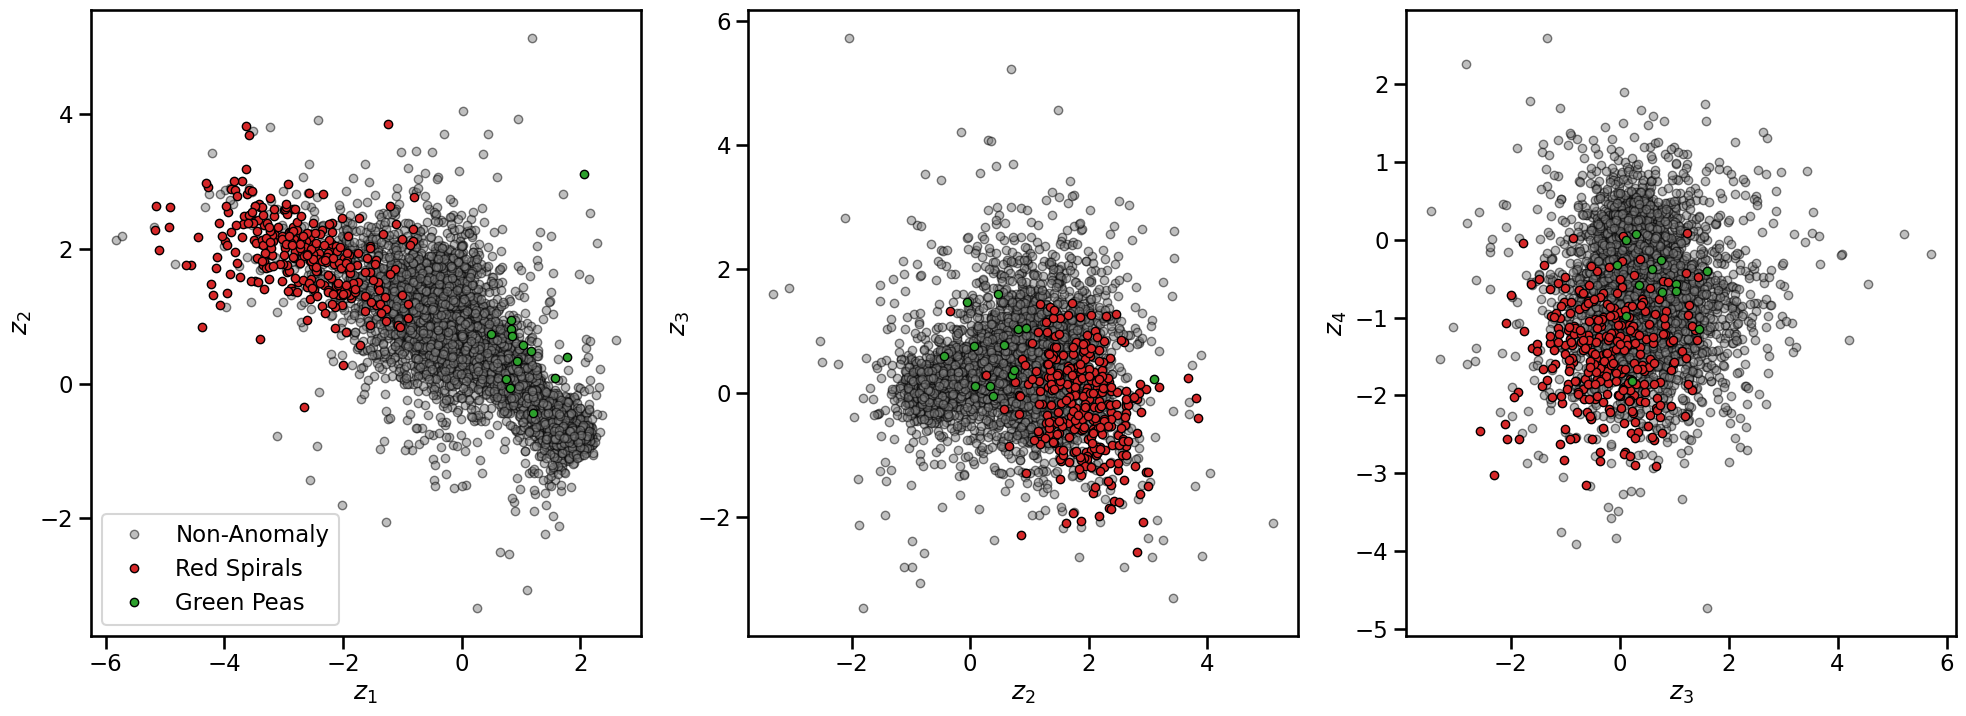

In [830]:
mu_list_uninf = []
y_list_uninf = []
for x, y in valid_loader:
    x = x.to(device)
    x_hat, mu, logvar = model_uninf(x)
    mu_list_uninf.append(mu.detach().numpy())
    y_list_uninf.append(y.detach().numpy())
mu_list_uninf = np.concatenate(mu_list_uninf)
y_list_uninf = np.concatenate(y_list_uninf)

df_uninf = pd.DataFrame(data = np.vstack([mu_list_uninf.T, y_list_uninf]).T, columns=['z1', 'z2', 'z3', 'z4', 'z5', 'Anomaly'])

sns.set_context("talk")
anomaly = {0:'Non-Anomaly', 1:'Red Spirals', 2:'Green Peas'}
cols = {0:'gray', 1:'tab:red', 2:'tab:green'}
groups = df_uninf.groupby('Anomaly')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7.5))
axs = ax.ravel()

for name, group in groups:
    if name == 0:
        alpha=0.5
    else:
        alpha = 1
    axs[0].plot(group['z1'], group['z2'], marker='o', linestyle='', markersize=6, color=cols[name], label=anomaly[name], lw=0.5, mec='k', alpha=alpha)
    axs[1].plot(group['z2'], group['z3'], marker='o', linestyle='', markersize=6, color=cols[name], label=anomaly[name], lw=0.5, mec='k', alpha=alpha)
    axs[2].plot(group['z3'], group['z4'], marker='o', linestyle='', markersize=6, color=cols[name], label=anomaly[name], lw=0.5, mec='k', alpha=alpha)
    axs[0].legend()
    axs[0].set_xlabel(r"$z_1$");
    axs[0].set_ylabel(r"$z_2$");
    axs[1].set_xlabel(r"$z_2$");
    axs[1].set_ylabel(r"$z_3$");
    axs[2].set_xlabel(r"$z_3$");
    axs[2].set_ylabel(r"$z_4$");
plt.tight_layout()
plt.savefig("AnomalyDetection_uninformedVAE.png",dpi=200, bbox_inches='tight')

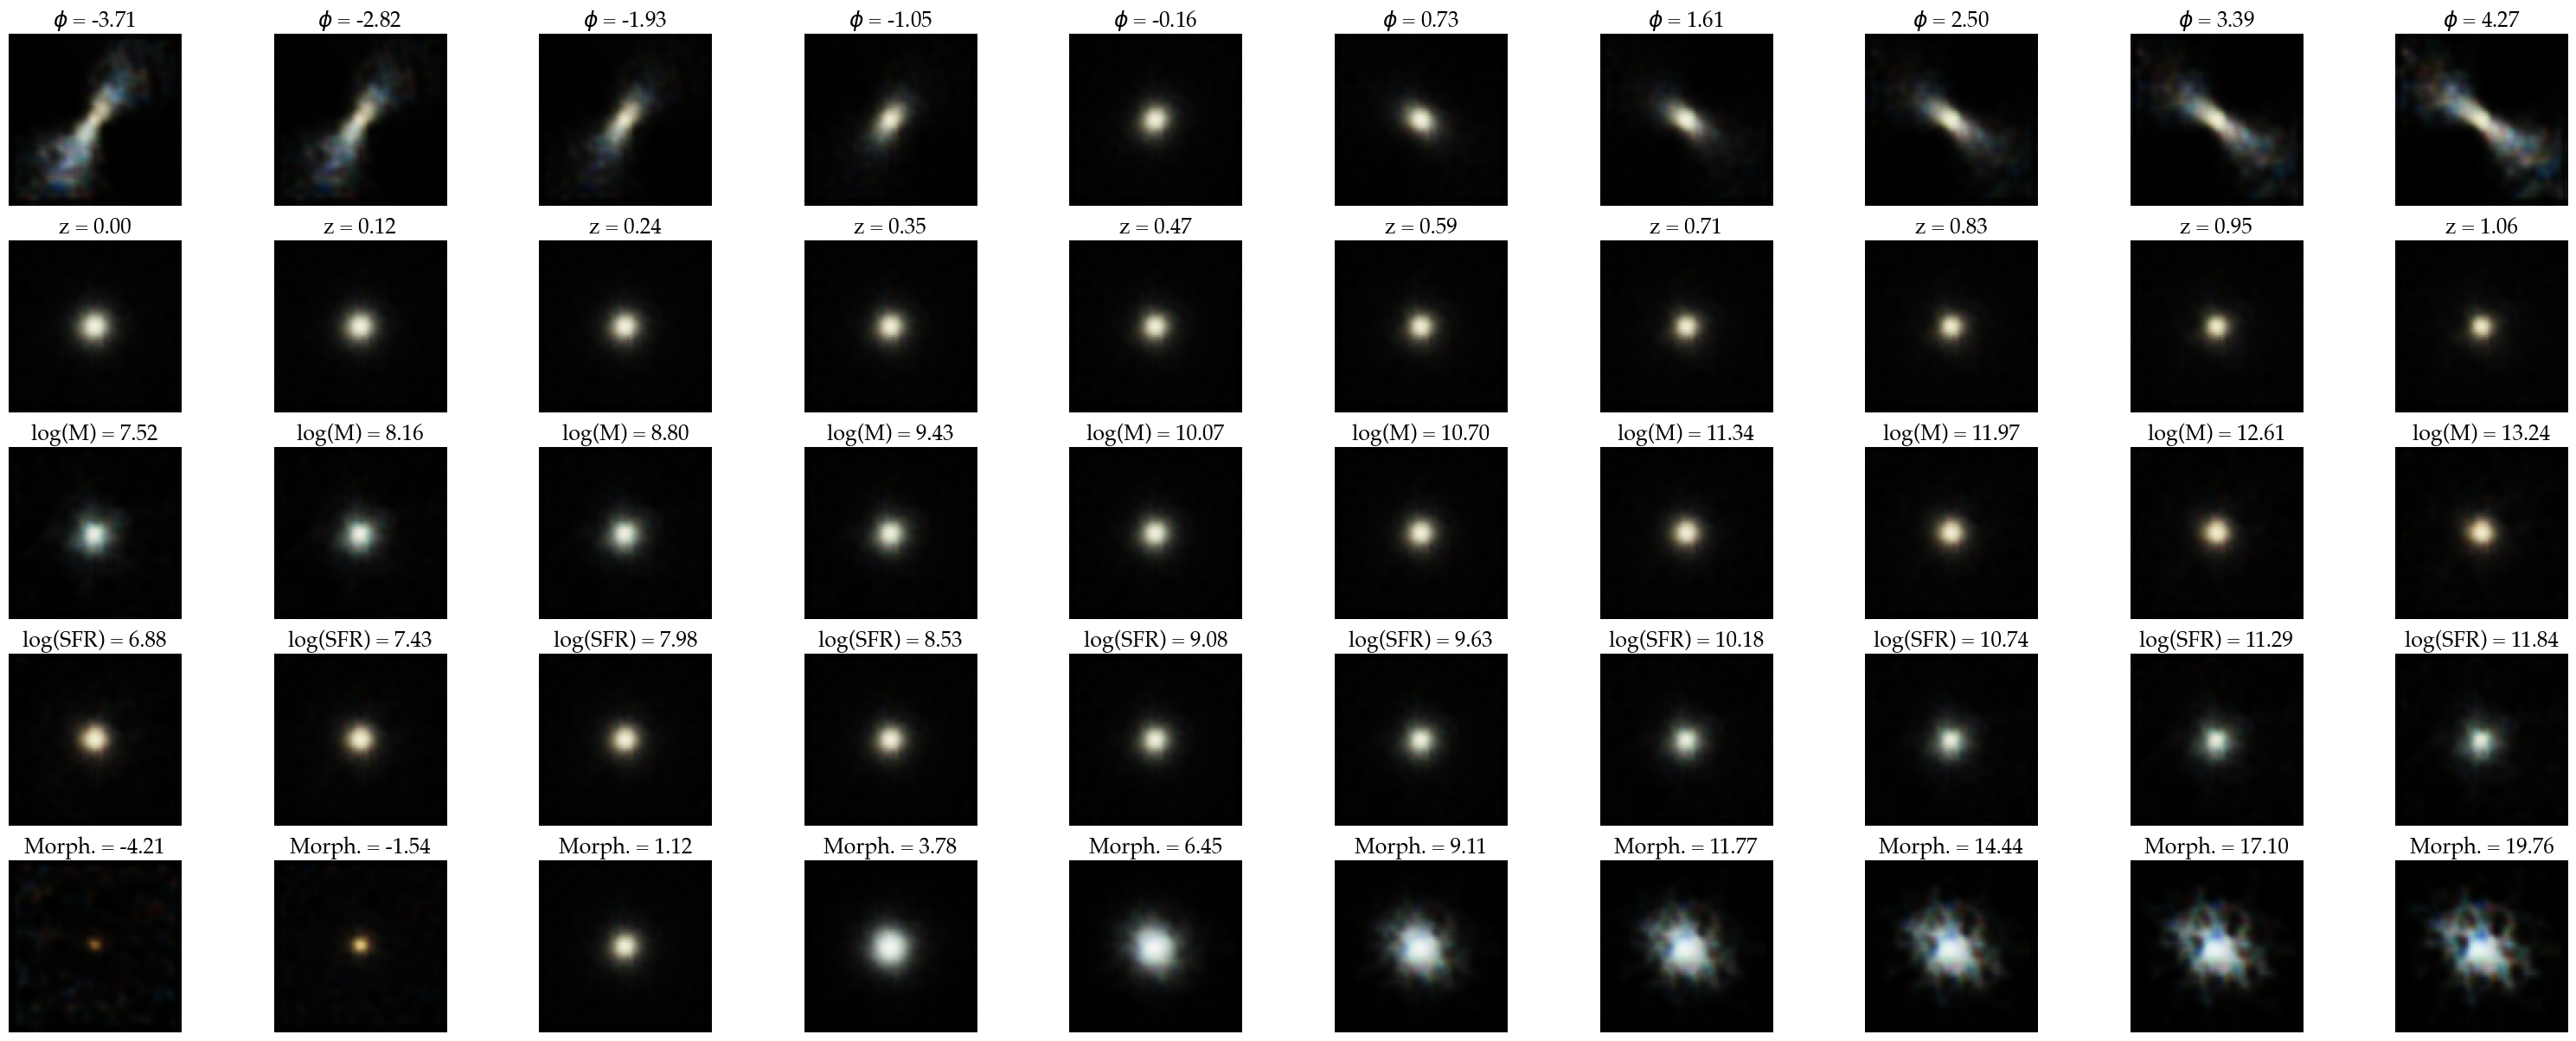

In [824]:
sns.set_context("talk")

def decode(vae_model, z):
    x_hat = vae_model.dec1(z)
    x_hat = F.interpolate(x_hat, size=(35, 35), mode='bilinear')
    x_hat = vae_model.dec2(x_hat)
    x_hat = F.interpolate(x_hat, size=(69, 69), mode='bilinear')
    return vae_model.dec3(x_hat)
    
fig, ax =plt.subplots(nrows=5, ncols=10, figsize=(40, 15))
axs = ax.ravel()

names = [r'$\phi$', 'z', 'log(M)', 'log(SFR)', 'Morph.']
for j in np.arange(5):
    for i in np.arange(10):
        if j == 1:
            paramMin = 0
        else:
            paramMin = np.nanmin(mu_list[:, j])
        paramMax = np.nanmax(mu_list[:, j])
        ParamRange = np.linspace(paramMin, paramMax, 10)

        tempSet = np.nanmean(mu_list, axis=0) 
        tempSet[j] = ParamRange[i]
        x_reconstructed = decode(model,  torch.FloatTensor(tempSet).to(device).unsqueeze(0))
        x_img = np.array(x_reconstructed.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1)).squeeze()
        ax[j, i].imshow(x_img)
        ax[j, i].axis('off')
        ax[j, i].set_title('%s = %.2f'%(names[j], ParamRange[i]), font='Palatino')
plt.subplots_adjust(wspace=-0.1, hspace=0.2)
plt.savefig("LatentGrid_GAMAZou26k_d5_learnedpa.png",dpi=200, bbox_inches='tight')

In [73]:
#Nearest neighbors of galaxies from red spirals and green peas
all_data = GalaxyDataset([F.interpolate(transform(x).unsqueeze(0), size=(69, 69), mode='bicubic').squeeze() for x in ZouGam['x']], ZouGam['y'], None)
all_loader = DataLoader(
    all_data,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)
mu_list_all = []
y_list_all = []
images_all = []
for x, y in all_loader:
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    images_all.append(x.detach().numpy())
    mu_list_all.append(mu.detach().numpy())
    y_list_all.append(y.detach().numpy())
mu_list_all = np.concatenate(mu_list_all)
y_list_all = np.concatenate(y_list_all)
images_all = np.concatenate(images_all)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

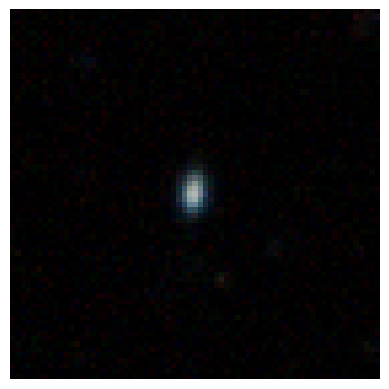

In [87]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from collections import Counter

#get the 10 nearest neighbors for each green pea galaxy
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(mu_list_all)
distances, indices = nbrs.kneighbors(mu_list_gp)
counts = Counter(indices.ravel())
gplike_gals = {key : val for key, val in counts.items() if (val > 1)}
gplike_imgs = images_all[list(gplike_gals.keys())]
for i in np.arange(len(gplike_imgs)):
    plt.imshow(np.moveaxis(gplike_imgs[i], 0, -1))
    plt.axis("off")
    plt.savefig("./GreenPeakLookAlike_%i.png"%i, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

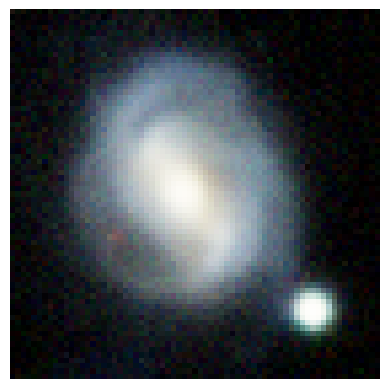

In [88]:
#get the 10 nearest neighbors for each red spiral galaxy
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(mu_list_all)
distances, indices = nbrs.kneighbors(mu_list_rsps)
counts = Counter(indices.ravel())
rsplike_gals = {key : val for key, val in counts.items() if (val > 50)}
rsplike_imgs = images_all[list(rsplike_gals.keys())]
for i in np.arange(len(rsplike_imgs)):
    plt.imshow(np.moveaxis(rsplike_imgs[i], 0, -1))
    plt.axis("off")
    plt.savefig("./RedSpiralLookAlike_%i.png"%i, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


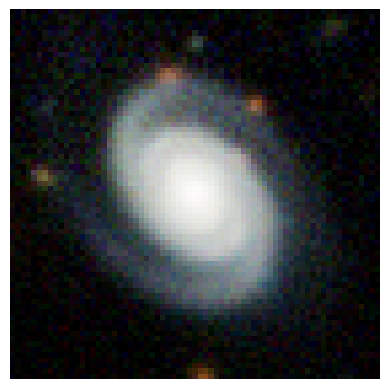

In [92]:
for i in np.arange(len(images_rsps)):
    plt.imshow(np.moveaxis(images_rsps[i], 0, -1))
    plt.axis("off")
    plt.savefig("./RedSpirals_%i.png"%i, bbox_inches='tight')
    if i == 5:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


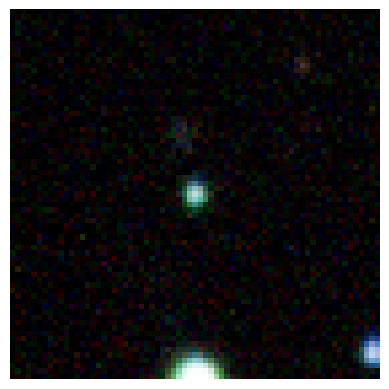

In [93]:
for i in np.arange(len(images_gp)):
    plt.imshow(np.moveaxis(images_gp[i], 0, -1))
    plt.axis("off")
    plt.savefig("./GreenPeas_%i.png"%i, bbox_inches='tight')
    if i == 5:
        break